# Simulation / bootstrapping and Fixed Effects

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

## Fixed Effects

(array([  9.,  40., 104., 211., 255., 220., 108.,  42.,   7.,   4.]),
 array([-2.98099301, -2.32330814, -1.66562328, -1.00793842, -0.35025356,
         0.3074313 ,  0.96511616,  1.62280102,  2.28048588,  2.93817075,
         3.59585561]),
 <BarContainer object of 10 artists>)

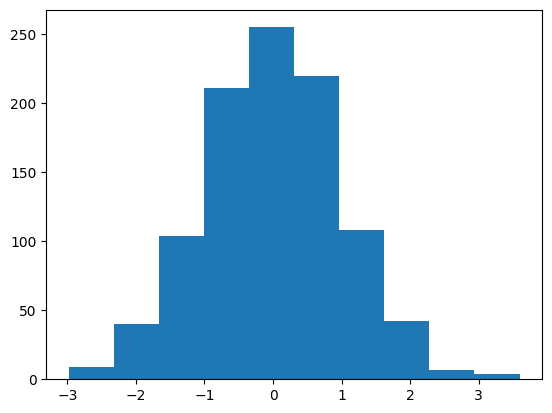

In [2]:
arr = np.random.normal(10, 5, 1000)
z_score = (arr - arr.mean())/arr.std()
plt.hist(z_score)

### Three hospitals: 1, 2, 3
### X = Z-score of drug administration
### Y = effect of drug (increase in white blood cell count)

In [3]:
np.random.seed(0)
num = 1000
X1 = np.random.normal(0, 1, (num,)) # scipy.stats.norm.rvs - alternative
X2 = np.random.normal(0, 1, (num,))
X3 = np.random.normal(0, 1, (num,))
Y1 = 3 * X1 + 5 + np.random.normal(0, 1, (num,))
Y2 = 3 * X2 + 10 + np.random.normal(0, 1, (num,))
Y3 = 3 * X3 + 15 + np.random.normal(0, 1, (num,))

### $Y_1 = 3 \cdot X_1 + 5 + \epsilon_{Y1}$

In [4]:
model = LinearRegression()
model.fit(X1.reshape(-1, 1), Y1)
print(model.coef_)
print(model.intercept_)

[3.00816248]
4.981426810419045


In [5]:
model = LinearRegression()
model.fit(X1.reshape(-1, 1), Y1)
print(model.coef_)
print(model.intercept_)

[3.00816248]
4.981426810419045


In [6]:
results = sm.OLS(Y1, X1).fit()
results.params

array([2.77724269])

In [7]:
results = sm.OLS(Y1, sm.add_constant(X1)).fit()

In [8]:
results.params

array([4.98142681, 3.00816248])

In [9]:
results.bse

array([0.03218777, 0.0325764 ])

In [10]:
results.rsquared

0.8952231076208007

In [11]:
1 - np.var(Y1 - results.predict(sm.add_constant(X1))) / np.var(Y1)

0.8952231076208008

In [12]:
1 - np.var(results.resid) / Y1.var()

0.8952231076208008

(array([  3.,   6.,  64., 173., 281., 255., 150.,  54.,  11.,   3.]),
 array([-3.72518583, -2.97114515, -2.21710447, -1.46306379, -0.7090231 ,
         0.04501758,  0.79905826,  1.55309895,  2.30713963,  3.06118031,
         3.81522099]),
 <BarContainer object of 10 artists>)

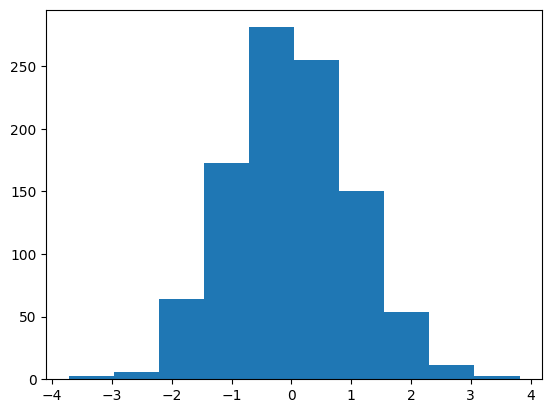

In [13]:
plt.hist(results.resid)

In [14]:
np.std(Y1 - results.predict(sm.add_constant(X1)))

1.01578114653031

In [15]:
np.std(results.resid)

1.01578114653031

In [16]:
root_mean_squared_error(Y1, results.predict(sm.add_constant(X1))) # Another way

1.0157811465303097

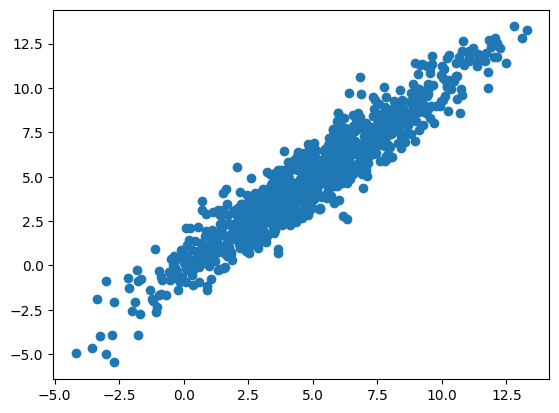

In [17]:
plt.scatter(results.predict(sm.add_constant(X1)), Y1)

In [18]:
Y = np.concatenate((Y1, Y2, Y3))
X = np.concatenate((X1, X2, X3))
results_combined = sm.OLS(Y, sm.add_constant(X)).fit()
results_combined.params # note that params do not match group 1, but likely will match group 2

array([9.99607883, 2.97648875])

In [19]:
results_combined.bse

array([0.07679134, 0.07910939])

In [20]:
results_combined.rsquared # rsquared is _worse_ than for group 1 alone

0.3207418838625441

In [21]:
np.std(results_combined.resid)

4.202929927077389

In [22]:
root_mean_squared_error(Y, results_combined.predict(sm.add_constant(X))) # another way

4.202929927077389

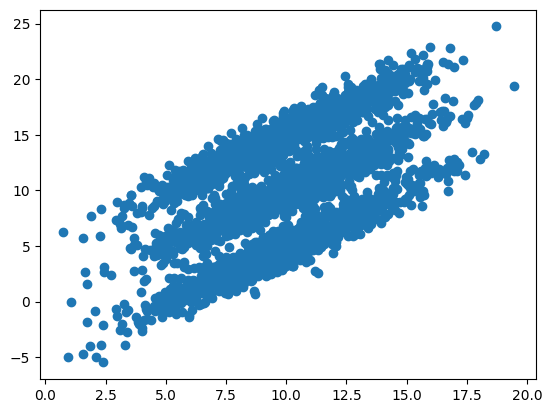

In [23]:
plt.scatter(results_combined.predict(sm.add_constant(X)), Y)

In [24]:
num

1000

In [25]:
groups = np.repeat([1, 2, 3], num)
X_fixed_effects = pd.get_dummies(groups) * 1
X_reshaped = X.reshape(-1, 1)
df_design = pd.DataFrame(np.hstack((X_reshaped, X_fixed_effects)), columns = ["X", "G1", "G2", "G3"])
results_fixed_effects = sm.OLS(Y, df_design).fit()
results_fixed_effects.params

X      2.986359
G1     4.980440
G2    10.028366
G3    14.980248
dtype: float64

In [ ]:
# G1 = const (5)
# G2 = const (5) + G2 (5) = 10
# G3 = const (5) + G3 (10) = 15

In [89]:
groups = np.repeat([1, 2, 3], num)
X_fixed_effects = pd.get_dummies(groups, drop_first=True)
X_design = np.hstack((X.reshape(-1, 1), X_fixed_effects))
df_design = pd.DataFrame(X_design, columns = ["X", "Group_2", "Group_3"])
results_fixed_effects = sm.OLS(Y, sm.add_constant(df_design)).fit()

In [170]:
results_fixed_effects.params

X      2.986359
G1     4.980440
G2    10.028366
G3    14.980248
dtype: float64

In [171]:
results_fixed_effects.bse

X     0.018820
G1    0.031626
G2    0.031616
G3    0.031630
dtype: float64

In [94]:
results_fixed_effects.rsquared

0.9616172265379285

In [95]:
np.std(results_fixed_effects.resid)

0.9990860787793621

In [96]:
np.std(Y - results_fixed_effects.predict(sm.add_constant(df_design)))

0.9990860787793621

In [97]:
root_mean_squared_error(Y, results_fixed_effects.predict(sm.add_constant(df_design)))

0.9990860787793621

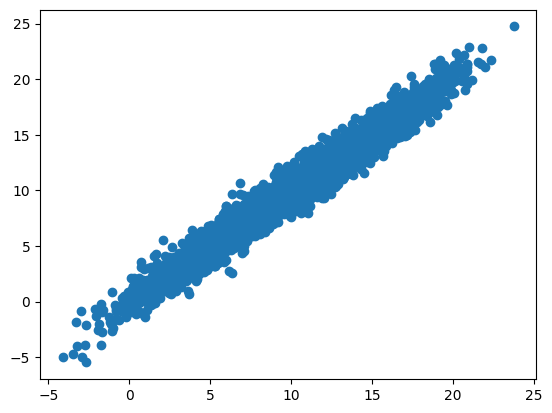

In [97]:
plt.scatter(results_fixed_effects.predict(sm.add_constant(df_design)), Y)

In [174]:
Y1 - <Y1> = 3 * (X1 - <X1>) + error
Y2 - <Y2> = 3 * (X2 - <X2>) + error
<Y1> = 3 * <X1> + 5
Y2 = 3 * X2 + 10 + np.random.normal(0, 1, (num,))
Y3 = 3 * X3 + 15 + np.random.normal(0, 1, (num,))

(4.845287280932355, 10.069031513256334, 14.827261039210718)

In [179]:
X = np.concatenate((X1 - X1.mean(), X2 - X2.mean(), X3 - X3.mean()))
Y = np.concatenate((Y1 - Y1.mean(), Y2 - Y2.mean(), Y3 - Y3.mean()))
results_demeaned = sm.OLS(Y, X).fit()

In [180]:
results_demeaned.params

array([2.986359])

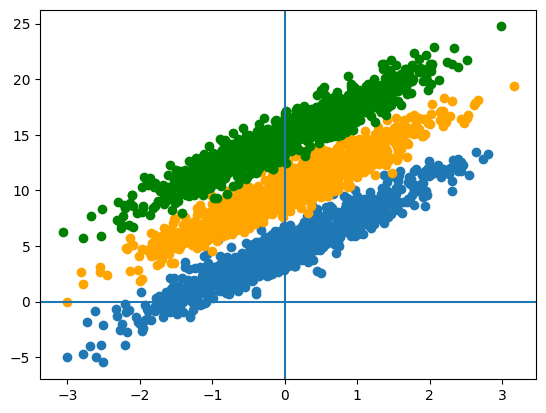

In [182]:
plt.scatter(X1 - X1.mean(), Y1)
plt.scatter(X2 - X2.mean(), Y2, color = "orange")
plt.scatter(X3 - X3.mean(), Y3, color = "green")
plt.axvline(0)
plt.axhline(0)

In [183]:
results_demeaned.bse

array([0.01881066])

In [113]:
results_demeaned.rsquared

0.8936652558014316

In [122]:
np.std(results_demeaned.resid)

0.9990860787793621

In [123]:
root_mean_squared_error(Y, results_demeaned.predict(X))

0.9990860787793621

# Simulation

In [184]:
# Suppose we want to know what happens if we do this simulation many times
np.random.seed(0)
num_iter = 1000
beta_1_list = list()
se_list = list()
for n in range(num_iter):
    num = 1000
    X1 = scipy.stats.norm.rvs(0, 1, (num,))
    X2 = scipy.stats.norm.rvs(0, 1, (num,))
    X3 = scipy.stats.norm.rvs(0, 1, (num,))
    Y1 = 3 * X1 + 5 + scipy.stats.norm.rvs(0, 1, (num,))
    Y2 = 3 * X2 + 10 + scipy.stats.norm.rvs(0, 1, (num,))
    Y3 = 3 * X3 + 15 + scipy.stats.norm.rvs(0, 1, (num,))
    X = np.hstack((X1 - X1.mean(), X2 - X2.mean(), X3 - X3.mean())) # demean the data
    Y = np.hstack((Y1 - Y1.mean(), Y2 - Y2.mean(), Y3 - Y3.mean()))
    results_demeaned = sm.OLS(Y, X).fit()
    beta_1_list.append(results_demeaned.params[0])
    se_list.append(results_demeaned.bse[0])

np.std(beta_1_list)

0.018680493613602415

In [185]:
np.mean(se_list)

0.01826263668136621

In [137]:
np.mean(beta_1_list)

3.0011668893443586

(array([  5.,   6.,   6.,  23.,  33.,  46.,  55.,  91., 100., 112., 127.,
        111.,  90.,  76.,  57.,  30.,  14.,  10.,   6.,   2.]),
 array([2.94523997, 2.95071436, 2.95618875, 2.96166314, 2.96713753,
        2.97261192, 2.97808631, 2.9835607 , 2.98903509, 2.99450948,
        2.99998387, 3.00545826, 3.01093266, 3.01640705, 3.02188144,
        3.02735583, 3.03283022, 3.03830461, 3.043779  , 3.04925339,
        3.05472778]),
 <BarContainer object of 20 artists>)

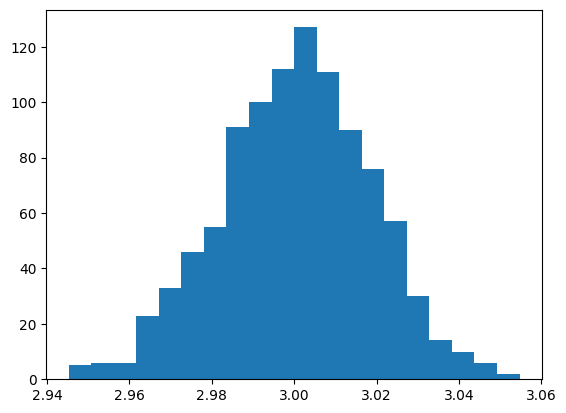

In [127]:
plt.hist(beta_1_list, bins = 20)